In [1]:
import os.path

import numpy as np
import pandas as pd
from scipy import linalg
from scipy.sparse import csr_matrix
from sklearn.preprocessing import OneHotEncoder

import Bio.PDB, warnings
pdb_list = Bio.PDB.PDBList()
pdb_parser = Bio.PDB.PDBParser()
from scipy.spatial import distance_matrix
from Bio import BiopythonWarning
warnings.simplefilter('ignore', BiopythonWarning)

from joblib import Parallel, delayed
import timeit

import matplotlib.pyplot as plt
%matplotlib inline

# # --- Import our Code ---# #
#import emachine as EM
from direct_info import direct_info

# import data processing and general DCA_ER tools
from data_processing import data_processing
import ecc_tools as tools
from pathlib import Path
np.random.seed(1)


def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)

## Get list of Protein Families Simulated in Biowulf

In [2]:
import os
import numpy as np

biowulf_dir = '/data/cresswellclayec/DCA_ER/biowulf'
data_path = Path('Pfam-A.full')
DCA_dir = Path('/data/cresswellclayec/DCA_ER/')

pfam_list = np.loadtxt('%s/full_pfam_list.txt' % biowulf_dir,dtype='str')
print(pfam_list)

['PF18577' 'PF01262' 'PF07468' 'PF18774' 'PF01686' 'PF03496' 'PF14525'
 'PF14542' 'PF18277' 'PF13911' 'PF03756' 'PF18671' 'PF13502' 'PF03678'
 'PF00245' 'PF08023' 'PF09261' 'PF01425' 'PF14749' 'PF05829' 'PF10470'
 'PF00324' 'PF00928' 'PF06369' 'PF09290' 'PF11657' 'PF11700' 'PF02551'
 'PF10322' 'PF12695' 'PF05935' 'PF01990' 'PF06931' 'PF06541' 'PF05270'
 'PF16747' 'PF09156' 'PF01061' 'PF10775' 'PF00186' 'PF06052' 'PF12780'
 'PF14196' 'PF03228' 'PF10327' 'PF00389' 'PF13279' 'PF02675' 'PF03376'
 'PF10014' 'PF03078' 'PF13654' 'PF14469' 'PF02771' 'PF08843' 'PF10318'
 'PF01120' 'PF11527' 'PF04336' 'PF07280' 'PF13336' 'PF11330' 'PF01094'
 'PF00764' 'PF08792' 'PF13356' 'PF12781' 'PF14921' 'PF05195' 'PF00843'
 'PF17050' 'PF11032' 'PF02438' 'PF12966' 'PF04548' 'PF17771' 'PF07703'
 'PF13508' 'PF03780' 'PF10997' 'PF10334' 'PF01757' 'PF00207' 'PF08882'
 'PF04029' 'PF06770' 'PF12156' 'PF18769' 'PF00266' 'PF17366' 'PF05176'
 'PF17837' 'PF18084' 'PF11591' 'PF10899' 'PF01064' 'PF09668' 'PF13479'
 'PF04

In [3]:
from os.path import exists

di_dir = '/data/cresswellclayec/DCA_ER/protein_data/di'

mf_di = []
er_di = []
pmf_di = []
pplm_di = []
full_pfam_di = []

for pfam in pfam_list:
    mf_filename = '%s/%s_MF_di.npy' % (di_dir, pfam)
    er_filename = '%s/%s_ER_di.npy' % (di_dir, pfam)
    pydca_mf_filename = '%s/%s_DI_pydca_mf_di.npy' % (di_dir, pfam)
    pydca_plm_filename = '%s/%s_DI_pydca_plm_di.npy' % (di_dir, pfam)
    if exists(mf_filename):
        mf_di.append(pfam)
    if exists(er_filename):
        er_di.append(pfam)
    if exists(pydca_mf_filename):
        pmf_di.append(pfam)
    if exists(pydca_plm_filename):
        pplm_di.append(pfam)
    
    if exists(mf_filename) and exists(er_filename) and exists(pydca_mf_filename) and exists(pydca_plm_filename):
        full_pfam_di.append(pfam)
print('Of the %d Pfams:' % len(pfam_list))
print('%d completed MF sims' % len(mf_di))
print('%d completed ER sims' % len(er_di))
print('%d completed pMF sims' % len(pmf_di))
print('%d completed pplm sims' % len(pplm_di))
print('Pfams with all completed: ', full_pfam_di)

Of the 118 Pfams:
14 completed MF sims
29 completed ER sims
9 completed pMF sims
9 completed pplm sims
Pfams with all completed:  ['PF18577', 'PF00186', 'PF05195']


Original Sequence length:  52
After removing bad sequences, tpdb is now  44
3
After removing bad sequences, tpdb is now  42
s after data_processing:  (44, 47)
Reference sequence (tpdb, s_ipdb) is sequence # 42
shape of s 
import from /data/cresswellclayec/DCA_ER/Pfam-A.full/PF18577/msa.npy
 (44, 47)
/data/cresswellclayec/DCA_ER/Pfam-A.full/PF18577
number of pdb structures: 5
    PDB CHAIN  PDB_START  PDB_END PFAM_ACCESSION       PFAM_NAME  \
0  101m     A          7      113        PF00042          Globin   
1  102l     A         24      149        PF00959  Phage_lysozyme   
2  102m     A          7      113        PF00042          Globin   
3  103l     A         24      151        PF00959  Phage_lysozyme   
4  103m     A          7      113        PF00042          Globin   

  AUTH_PDBRES_START AUTH_PDBRES_START_INS_CODE AUTH_PDBRES_END  \
0                 6                                        112   
1                24                                        148   
2              

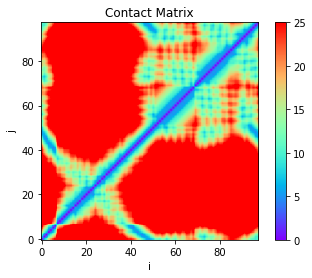

In [8]:
pfam_id = full_pfam_di[0]
ipdb = 0


printing = False
msa_npy_file = '/data/cresswellclayec/DCA_ER/Pfam-A.full/%s/msa.npy' % pfam_id
msa_fa_file  = '/data/cresswellclayec/DCA_ER/Pfam-A.full/%s/msa.fa' % pfam_id
pdb_ref_file = '/data/cresswellclayec/DCA_ER/Pfam-A.full/%s/pdb_refs.npy' % pfam_id
out_dir = '%sprotein_data/di/' % DCA_dir

msa_outfile, ref_outfile, s0, cols_removed, s_index, tpdb, orig_seq_len  = tools.npy2fa(pfam_id, msa_npy_file, 
                                                                                        pdb_ref_file=pdb_ref_file, 
                                                                                        ipdb=ipdb, preprocess=True,
                                                                                        gap_seqs=.2, gap_cols=.2, 
                                                                                        prob_low=.004, 
                                                                                        conserved_cols=.9, 
                                                                                        letter_format=False)

# Referencing the same dataframe may be useful so we dont always have to load individual ref files...
# however we also
individual_pdb_ref_file = Path(data_path, pfam_id, 'pdb_refs.npy')
pdb = np.load(individual_pdb_ref_file)
processed_data_dir = "%s/protein_data/data_processing_output" % DCA_dir

# delete 'b' in front of letters (python 2 --> python 3)
pdb = np.array([pdb[t,i].decode('UTF-8') for t in range(pdb.shape[0]) \
         for i in range(pdb.shape[1])]).reshape(pdb.shape[0],pdb.shape[1])


# Print number of pdb structures in Protein ID folder
npdb = pdb.shape[0]
print('number of pdb structures:',npdb)

# Create pandas dataframe for protein structure
pdb_df = pd.DataFrame(pdb,columns = ['PF','seq','id','uniprot_start','uniprot_end',\
                                 'pdb_id','chain','pdb_start','pdb_end'])
pdb_df.head()


# Load csv of PDB-PFAM mapping.
#    downloaded from 
#    ftp://ftp.ebi.ac.uk/pub/databases/msd/sifts/flatfiles/csv/pdb_pfam_mapping.csv.gz
pdb_id = pdb_df.iloc[ipdb]['pdb_id']
pdb_chain = pdb_df.iloc[ipdb]['chain']

pdb_pfam_map_file = Path('%s/protein_data/pdb_data/pdb_pfam_mapping.csv' % DCA_dir)
pdb_map_df = pd.read_csv(pdb_pfam_map_file, sep=',', header=1)
print(pdb_map_df.head())

pdb_id_map_df = pdb_map_df.loc[pdb_map_df['PDB']==pdb_id.lower()]
pdb_pfam_map = pdb_id_map_df.loc[pdb_id_map_df['CHAIN']==pdb_chain]

## Generate and Plot Contact Map from PDB coordinates!
# Check that pdb--pfam mapping is unique
if pdb_pfam_map.shape[0] > 1:
    print('Unable to get unique PDB-->Pfam mapping')
    print(pdb_pfam_map)

# pp_range = [pdb_info['PDB_START'], pdb_info['PDB_END']]
pp_range = [pdb_pfam_map.iloc[0]['PDB_START'], pdb_pfam_map.iloc[0]['PDB_END']]
print('Polypeptide range for contact map: ', pp_range)


pdb_out = "%s/protein_data/pdb_data" % DCA_dir
# Directory for storing PDB data locally
# returns contact map with the appropriate columns removed..
# For list of retained columns us s_index
ct, ct_full, n_amino_full, poly_seq_curated = tools.contact_map(pdb, ipdb, pp_range, cols_removed, s_index, pdb_out_dir=pdb_out, printing=printing)
print(ct.shape)
print(ct_full.shape)


ct_mat = ct
# tools.hide_toggle()
print('Contact matrix shape:', ct_mat.shape)

plt.tight_layout(h_pad=1, w_pad=1.5)
plt.title('Contact Matrix')
plt.imshow(ct_mat,cmap='rainbow',origin='lower')
plt.xlabel('i')
plt.ylabel('j')
plt.clim(0,25)
plt.colorbar(fraction=0.045, pad=0.05)
# 'I'' 'Q' 'S' 'R' 'V' 'E' 'T' 'V' 'P' 'Y' 'L' 'F' 'C' 'R' 'S' 'E' 'E' 'V'
#  'R' 'P' 'A' 'G' 'M' 'V' 'W' 'Y' 'S' 'I' 'L' 'K' 'D' 'T' 'K' 'I' 'T' 'C'
#  'E' 'E' 'K' 'M' 'V' 'S' 'M' 'A' 'R' 'N' 'T



# Plot AUC Curves
# Find ct_threshold (2-6 Angstrom) which gives best contact prediction for ER
auc_ER = np.zeros(n)
for i in range(n):
    try:
        p,tp,fp = roc_curve(ct_mat, ER_di, ct_thres[i])
        if i in iplot:
            plt.plot(fp,tp,label='thres = %3.2f'%ct_thres[i])
        auc_ER[i] = tp.sum()/tp.shape[0]
    except(RuntimeWarning):
        auc_ER[i] = 0

# Get ER method's best contact prediction
i0_ER = np.argmax(auc_ER)
print('ER auc max:',ct_thres[i0_ER],auc_ER[i0_ER])
p0_ER,tp0_ER,fp0_ER = tools.roc_curve(ct_mat,ER_di,ct_thres[i0_ER])

# find optimal threshold of distance
auc_MF = np.zeros(n)

for i in range(n):
    try:
        p,tp,fp = roc_curve(ct_mat, MF_di, ct_thres[i])
        if i in iplot:
            plt.plot(fp,tp,label='thres = %3.2f'%ct_thres[i])
        auc_MF[i] = tp.sum()/tp.shape[0]
    except(RuntimeWarning):
        auc_MF[i] = 0
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
        
i0_MF = np.argmax(auc_MF)
print('auc max:',ct_thres[i0_MF],auc_MF[i0_MF])
p0_MF,tp0_MF,fp0_MF = tools.roc_curve(ct,MF_di,ct_thres[i0_MF])

